In [46]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from math import isnan

In [47]:
pilot_file = "results_pilot_april_20.csv"
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]

In [48]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_part = "Answer_noun_particularity" + str(idx + 1)
            var_part_c = "Answer_noun_part_certainty" + str(idx + 1)
            var_kind = "Answer_noun_class" + str(idx + 1)
            var_kind_c = "Answer_noun_class_certainty" + str(idx + 1)
            var_abs = "Answer_noun_abs" + str(idx + 1)
            var_abs_c = "Answer_noun_abs_certainty" + str(idx + 1)
            temp_dict['part'] = getattr(row, var_part)
            temp_dict['part_conf'] = getattr(row, var_part_c)
            temp_dict['kind'] = getattr(row, var_kind)
            temp_dict['kind_conf'] = getattr(row, var_kind_c)
            temp_dict['abs'] = getattr(row, var_abs)
            temp_dict['abs_conf'] = getattr(row, var_abs_c)
            temp_dict['worker_id'] = row.WorkerId
            global_list.append(temp_dict)
    
    return pd.DataFrame(global_list)

In [49]:
pilot_data = extract_dataframe(data)
# Rearrange the columns
cols = ['worker_id','sent_noun','sent_id', 'raw_sentence','predicate','noun','noun_token','part','part_conf',
        'kind','kind_conf','abs','abs_conf']
pilot_data['sent_noun'] = pilot_data['sent_id'].map(lambda x : x) + "_" +\
                           pilot_data['noun_token'].map(lambda x: str(x))
pilot_data = pilot_data[cols]
pilot_data.head()

,worker_id,sent_noun,sent_id,raw_sentence,predicate,noun,noun_token,part,part_conf,kind,kind_conf,abs,abs_conf
0,A2M6GFFEYJ5XP,en-ud-train.conllu sent_8206_3,en-ud-train.conllu sent_8206,Where in the world is Iguazu ?,Where,world,3,True,4,False,4,False,4
1,A2M6GFFEYJ5XP,en-ud-train.conllu sent_8206_5,en-ud-train.conllu sent_8206,Where in the world is Iguazu ?,Where,Iguazu,5,True,4,False,4,False,4
2,A2M6GFFEYJ5XP,en-ud-train.conllu sent_5978_4,en-ud-train.conllu sent_5978,"Yet , there is warmth and a familiarity with t...",is,warmth,4,False,4,False,4,True,4
3,A2M6GFFEYJ5XP,en-ud-train.conllu sent_6541_2,en-ud-train.conllu sent_6541,For those who believe ....................,believe,who,2,False,4,True,4,False,4
4,A2M6GFFEYJ5XP,en-ud-train.conllu sent_7297_2,en-ud-train.conllu sent_7297,Walk 2 blocks then turn right again .,Walk,blocks,2,True,2,False,2,False,4


### Response distribution

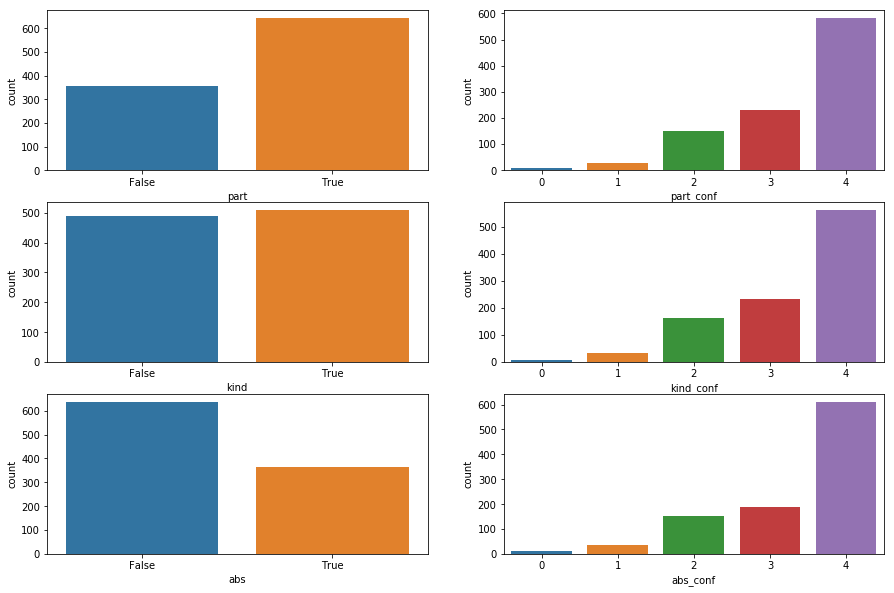

In [50]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
sns.countplot(x='part', data=pilot_data, ax=axs[0][0])
sns.countplot(x='part_conf', data=pilot_data, ax=axs[0][1])
sns.countplot(x='kind', data=pilot_data, ax=axs[1][0])
sns.countplot(x='kind_conf', data=pilot_data, ax=axs[1][1])
sns.countplot(x='abs', data=pilot_data, ax=axs[2][0])
sns.countplot(x='abs_conf', data=pilot_data, ax=axs[2][1])

plt.show()

## Inter Annotator agreement

## Raw agreement

In [51]:
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys

instant_agreement, key_inst = calc_raw_agreement(pilot_data, 'sent_noun', 'part')
start_agreement, key_start = calc_raw_agreement(pilot_data, 'sent_noun', 'kind')
end_agreement, key_end = calc_raw_agreement(pilot_data, 'sent_noun', 'abs')

####### Raw Count for part ###########
Total count of unique sent_noun is 196
Raw count of matched for part is 64
Inter-annotator agreement for part is 32.6530612244898%


####### Raw Count for kind ###########
Total count of unique sent_noun is 196
Raw count of matched for kind is 54
Inter-annotator agreement for kind is 27.55102040816326%


####### Raw Count for abs ###########
Total count of unique sent_noun is 196
Raw count of matched for abs is 7
Inter-annotator agreement for abs is 3.571428571428571%




## Average of accuracy and kappa for each pair

In [64]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    kappas = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])

        if temp1 == temp2:
            kappas.append(1)
            accuracies.append(1)
            continue
        kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
        
    return kappas, accuracies

def rank_correlation(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: pearson rank correlation

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    corrs = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])

        if temp1 == temp2:
            accuracies.append(1)
            corrs.append(1)
            continue
        corrs.append(spearman(temp1, temp2)[0])
        accuracies.append(accuracy(temp1, temp2))
        
    return corrs, accuracies

In [65]:
kappas = {}
corrs = {}
accs = {}
variables = ['part', 'kind', 'abs']
variables_ord = ['part_conf', 'kind_conf', 'abs_conf']
for var in variables:
    kappas[var], accs[var] = average_kappa_acc(pilot_data, 'worker_id', 'sent_noun', var)

for var in variables_ord:
    corrs[var], accs[var] = rank_correlation(pilot_data, 'worker_id', 'sent_noun', var)

/Users/venkat/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/venkat/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


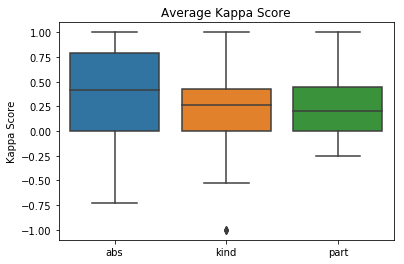

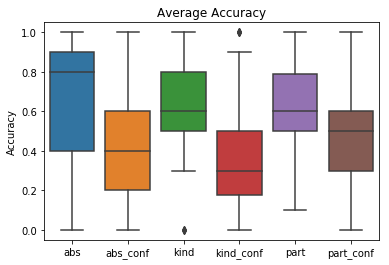

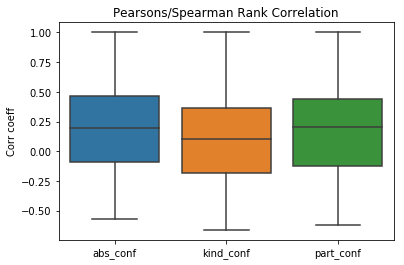

In [66]:
kappa_data = pd.DataFrame.from_dict(kappas)
acc_data = pd.DataFrame.from_dict(accs)
corr_data = pd.DataFrame.from_dict(corrs)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score', title="Average Kappa Score")
plt.show()

ax = sns.boxplot(data=acc_data)
ax.set(ylabel='Accuracy', title="Average Accuracy")
plt.show()

ax = sns.boxplot(data=corr_data)
ax.set(ylabel='Corr coeff', title="Pearsons/Spearman Rank Correlation")
plt.show()